<a href="https://colab.research.google.com/github/mvlier/topapprox/blob/main/Interactive_Tutorial_topapprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the latest topapprox package

This may take around a minute.

In [ ]:
!pip install git+https://github.com/mvlier/topapprox@main

In [ ]:
# we need to install additional packages for some examples
!pip install -U -q cripser persim

# Tutorial

Import the package.

In [1]:
import topapprox as ta

Import other necessary packages for this tutorial.

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['text.usetex'] = False


##  Toy example with a 2D image

We can construct an image by setting the values of each pixel as follows.

In [3]:
img = np.array([[0, 5, 3],\
                [5,5.1,4],\
                [2, 5, 1]])

And we can visualize the image with seaborn as follows.

<Axes: >

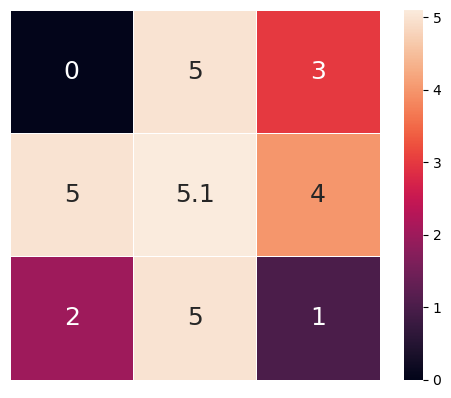

In [4]:
sns.heatmap(img, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

### PH0: 0-dimensional

<Axes: >

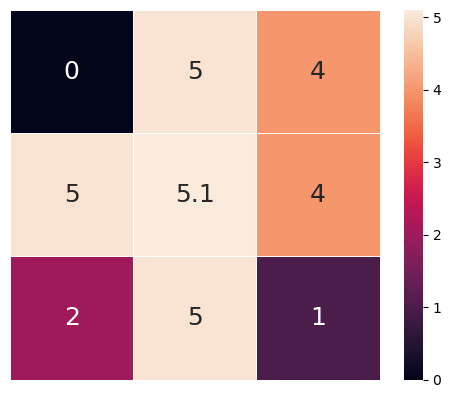

In [5]:
uf = ta.TopologicalFilterImage(img, dual=False)
img_filtered = uf.highpass_filter(2)
sns.heatmap(img_filtered, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

<Axes: >

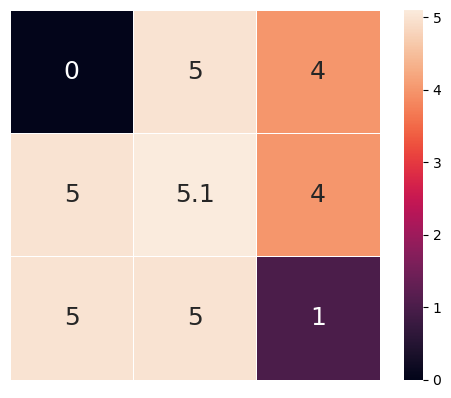

In [6]:
img_filtered = uf.highpass_filter(3.2)
sns.heatmap(img_filtered, annot=True, linewidths=0.5, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":18})

In [7]:
uf.persistence

array([[ 0., inf,  0.],
       [ 3.,  4.,  2.],
       [ 2.,  5.,  6.],
       [ 1.,  5.,  8.]])

## PH1: 1-dimensional

In [8]:
uf = ta.TopologicalFilterImage(img, dual=True)
uf.highpass_filter(2)

array([[0., 5., 3.],
       [5., 5., 4.],
       [2., 5., 1.]])

In [9]:
uf.highpass_filter(3.2)

array([[0., 5., 3.],
       [5., 5., 4.],
       [2., 5., 1.]])

In [10]:
uf.persistence

array([[-inf,  inf,  0. ],
       [-5.1, -5. , 12. ]])

## Example with a real image

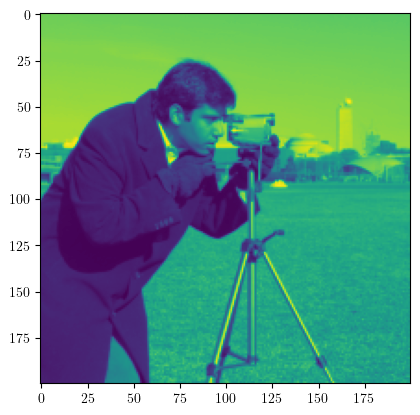

In [3]:
from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from tqdm.auto import tqdm
import cripser, persim

n,m = 200,200
img = resize(skimage.data.camera(),(n,m))
plt.imshow(img)

  0%|          | 0/4 [00:00<?, ?it/s]

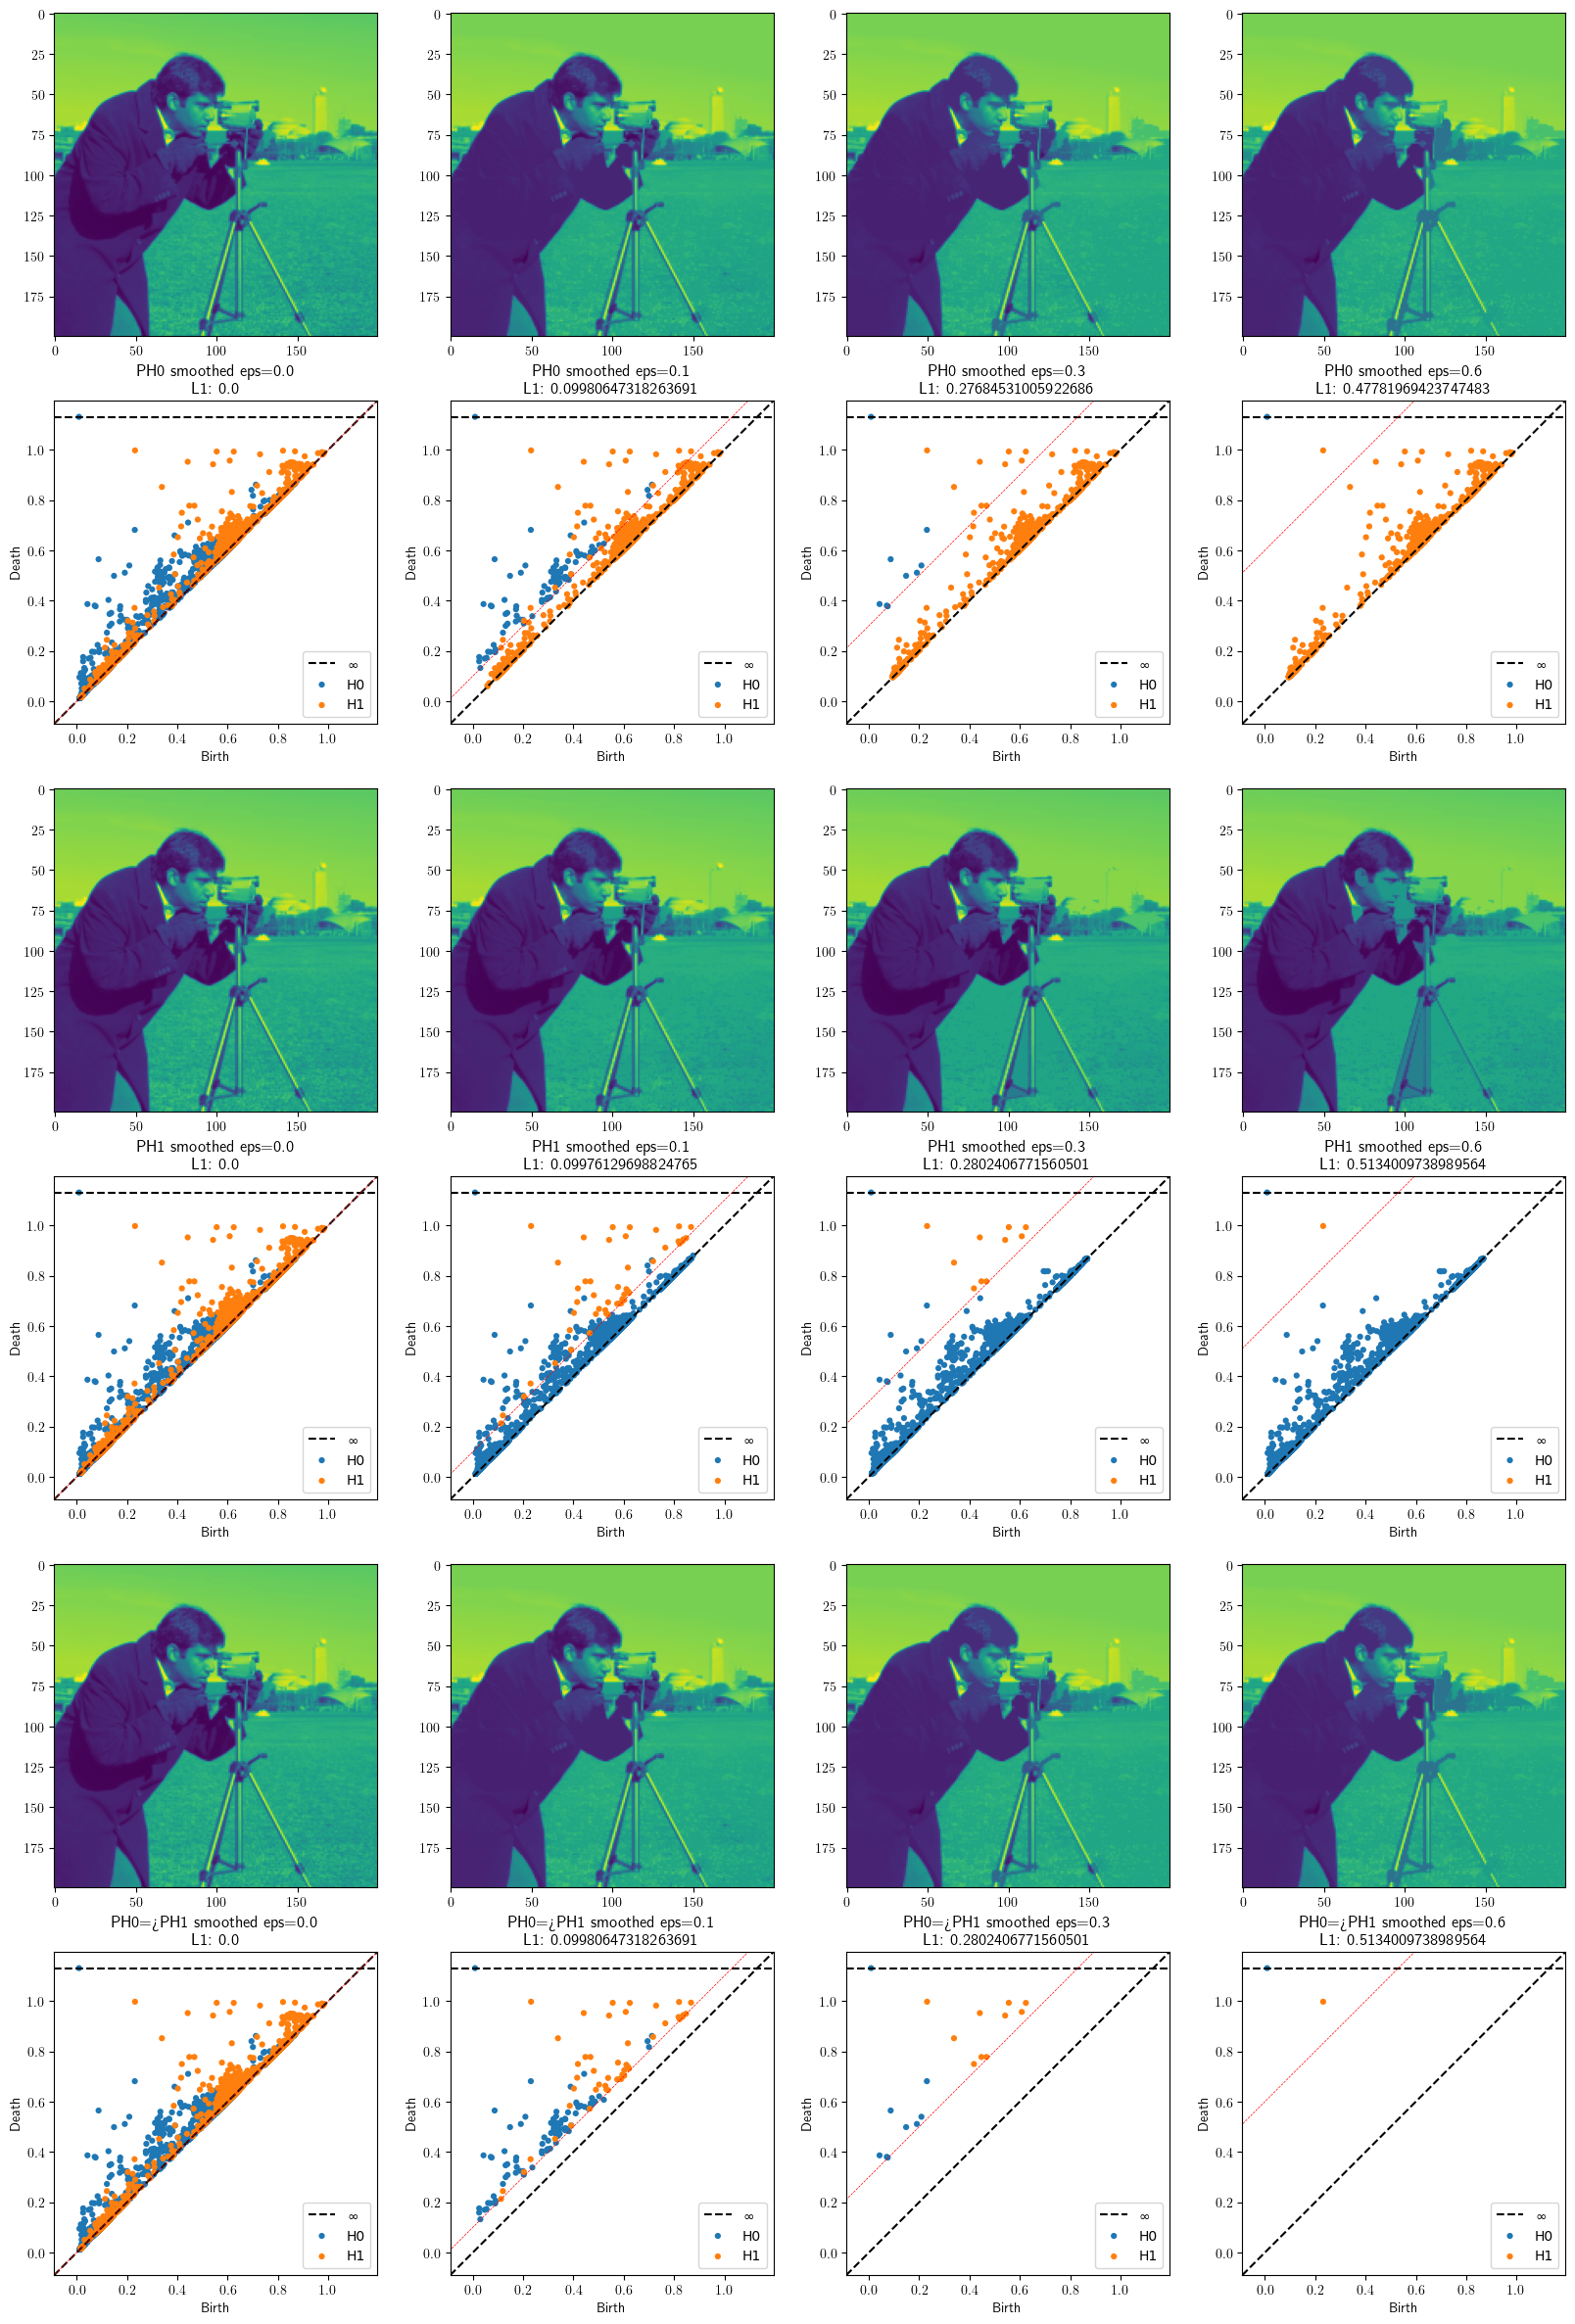

In [4]:
# filtering with different thresholds

thresholds=[0.0,0.1,0.3,0.6] # filtering thresholds
PD_original = cripser.computePH(img)
PD_original = [PD_original[PD_original[:,0]==i,1:3] for i in range(2)]

fig, axs = plt.subplots(6,len(thresholds),figsize=(20,30))
smoothed={}
smoothed1={}
smoothed2={}
a=ta.TopologicalFilterImage(img)
b=ta.TopologicalFilterImage(img, dual=True)
for i,s in enumerate(tqdm(thresholds)):
  PD_cutoff = [PD_original[i][PD_original[i][:,1]-PD_original[i][:,0]>=s] for i in range(2)]

  # PH0 smoothing
  smoothed[s] =a.highpass_filter(epsilon=s)
  axs[0,i].imshow(smoothed[s])
  PD_smoothed = cripser.computePH(smoothed[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  PD_smoothed_cutoff = [PD_smoothed[i][PD_smoothed[i][:,1]-PD_smoothed[i][:,0]>=s] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[1,i])
  axs[1,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")
  axs[1,i].set_title(f'PH0 smoothed eps={s} \n L1: {np.max(np.abs(smoothed[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])}\n PH1: {persim.bottleneck(PD_smoothed_cutoff[1],PD_cutoff[1])}')

  # PH1 smoothing
  smoothed1[s] =b.highpass_filter(epsilon=s)
  axs[2,i].imshow(smoothed1[s])
  PD_smoothed = cripser.computePH(smoothed1[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  PD_smoothed_cutoff = [PD_smoothed[i][PD_smoothed[i][:,1]-PD_smoothed[i][:,0]>=s] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[3,i])
  axs[3,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")
  axs[3,i].set_title(f'PH1 smoothed eps={s} \n L1: {np.max(np.abs(smoothed1[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])}\n PH1: {persim.bottleneck(PD_smoothed_cutoff[1],PD_cutoff[1])}')

  # PH0 => PH1 smoothing
  c=ta.TopologicalFilterImage(smoothed[s],dual=True)
  smoothed2[s] = c.highpass_filter(epsilon=s)
  axs[4,i].imshow(smoothed[s])
  PD_smoothed = cripser.computePH(smoothed2[s])
  PD_smoothed = [PD_smoothed[PD_smoothed[:,0]==i,1:3] for i in range(2)]
  persim.plot_diagrams(PD_smoothed,labels=["H0","H1"],ax=axs[5,i])
  axs[5,i].set_title(f'PH0=>PH1 smoothed eps={s} \n L1: {np.max(np.abs(smoothed2[s]-img))}')# \n distance PH0: {persim.bottleneck(PD_smoothed[0],PD_cutoff[0])} \n PH1: {persim.bottleneck(PD_smoothed[1],PD_cutoff[1])}')
  axs[5,i].plot([-5,5], [-5+s,5+s], '--', linewidth=0.5, c="r")


In [5]:
# setting keep_basin=True is slower for the first filtering but faster for later filtering
n,m = 300,300
img = resize(skimage.data.camera(),(n,m))
dual = False

%time tf = ta.TopologicalFilterImage(img, dual=dual)
%time tf2 = ta.TopologicalFilterImage(img, dual=dual)
for i,s in enumerate(thresholds):
    print("\nepsilon",s)
    print("Compute persistence everytime")
    %time u = tf.highpass_filter(s, keep_basin=False)
    print("Re-use persistence")
    %time v = tf2.highpass_filter(s, keep_basin=True)
    #print(np.allclose(u,v))

CPU times: user 496 ms, sys: 11.2 ms, total: 507 ms
Wall time: 519 ms
CPU times: user 433 ms, sys: 14.4 ms, total: 447 ms
Wall time: 447 ms

epsilon 0.0
Compute persistence everytime
CPU times: user 567 ms, sys: 1.36 ms, total: 568 ms
Wall time: 572 ms
Re-use persistence
CPU times: user 4.46 s, sys: 114 ms, total: 4.58 s
Wall time: 4.6 s

epsilon 0.1
Compute persistence everytime
CPU times: user 560 ms, sys: 1.57 ms, total: 561 ms
Wall time: 564 ms
Re-use persistence
CPU times: user 145 ms, sys: 1.09 ms, total: 146 ms
Wall time: 148 ms

epsilon 0.3
Compute persistence everytime
CPU times: user 562 ms, sys: 3.2 ms, total: 566 ms
Wall time: 570 ms
Re-use persistence
CPU times: user 18.4 ms, sys: 154 µs, total: 18.5 ms
Wall time: 18.7 ms

epsilon 0.6
Compute persistence everytime
CPU times: user 565 ms, sys: 1.88 ms, total: 567 ms
Wall time: 569 ms
Re-use persistence
CPU times: user 18.4 ms, sys: 97 µs, total: 18.5 ms
Wall time: 18.6 ms
